In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict
import random

In [3]:
import matplotlib.pyplot as plt
import nengo_spa as spa
from scipy.stats import sem
import seaborn as sns
import xarray as xr

In [4]:
from cue.model.amlearn import AML
from cue.aml_rapenc import Protocol, Trial, eval_pop_responses, slice_by_stim
from cue.utils.plotting import *

In [5]:
style()

## Demonstrating rapid encoding by individual neurons

In [6]:
cache_file = 'aml_rapenc.npz'
try:
    data = np.load(cache_file)
except FileNotFoundError:
    data = defaultdict(list)
    for seed in list(range(1)):
        protocol = Protocol(seed=seed)
        trial = Trial(protocol, seed + 1)
        trial.run()
        for k, v in eval_pop_responses(protocol, trial).items():
            data[k].append(v)
    data = {k: xr.concat(v, dim='spikes') for k, v in data.items()}
    np.savez(cache_file, **data)

In [7]:
def plot_with_sem(data, ax=None, label=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    dt = 0.05
    x = (np.arange(-.75, 1., dt) + dt) * 1e3
    m = np.mean(data, axis=1)
    s = sem(data, axis=1)
    ax.fill_between(x, m - s, m + s, alpha=0.3, **kwargs)
    ax.plot(x, m, label=label, **kwargs)

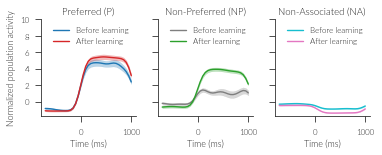

In [8]:
fig = plt.figure(figsize=(textwidth, row_height))

ax1 = fig.add_subplot(1, 3, 1)
plot_with_sem(data['p_bl'], ax1, label="Before learning", color='tab:blue')
plot_with_sem(data['p_al'], ax1, label="After learning", color='tab:red')
ax1.set_title("Preferred (P)")
ax1.set_ylabel("Normalized population activity")
ax1.set_xlabel("Time (ms)")
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2, sharex=ax1, sharey=ax1)
plot_with_sem(data['np_bl'], ax2, label="Before learning", color='tab:gray')
plot_with_sem(data['np_al'], ax2, label="After learning", color='tab:green')
ax2.set_title("Non-Preferred (NP)")
ax2.set_xlabel("Time (ms)")
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)
plot_with_sem(data['na_bl'], ax3, label="Before learning", color='tab:cyan')
plot_with_sem(data['na_al'], ax3, label="After learning", color='tab:pink')
ax3.set_title("Non-Associated (NA)")
ax3.set_xlabel("Time (ms)")
ax3.legend()
ax3.set_ylim(top=10)

for ax in fig.axes:
    ax.label_outer()

sns.despine(fig)
fig.tight_layout()

In [9]:
save_tight_fig(fig, '../../../phd-thesis/figures/aml-population-response.pdf')

### Spike plot

In [10]:
protocol = Protocol(seed=0)
trial = Trial(protocol, 1)
trial.run()

/home/jgosmann/Documents/projects/nengo_spa/nengo_spa/vocab.py:132: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=8)
  len(self._key2idx)))
/home/jgosmann/Documents/projects/nengo_spa/nengo_spa/vocab.py:132: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=11)
  len(self._key2idx)))
/home/jgosmann/Documents/projects/nengo_spa/nengo_spa/vocab.py:132: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=12)
  len(self._key2idx)))
/home/jgosmann/Documents/projects/nengo_spa/nengo_spa/vocab.py:132: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=13)
  len(self._key2idx)))
/home/jgosmann/Documents/projects/nengo_spa/nengo_spa/vocab.py:132: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=14)
  len(self._key2idx)))


Building finished in 0:00:03.                                                                                           
Simulating finished in 0:07:45.                                                                                         


In [11]:
mask = protocol.mask_screen(trial.trange)
long_sliced_bl = slice_by_stim(
    trial.trange[mask], trial.spikes[mask], protocol.screen_stimuli, protocol.onsets_screen,
    intervals=((-1., 1.),))
mask = protocol.mask_test(trial.trange)
long_sliced_al = slice_by_stim(
    trial.trange[mask], trial.spikes[mask], protocol.test_stimuli, protocol.onsets_test,
    intervals=((-1., 1.),))

In [12]:
pair_coding = eval_pop_responses(protocol, trial)['pair_coding']

In [13]:
[k for k, v in pair_coding.items() if len(v) > 0]

['L0', 'P0', 'L1']

In [14]:
def events_for_stim(t, sliced_spikes, p_stim, stim):
    return [t[np.where(onset[0][:, pair_coding[p_stim]][:, 0])[0]] for onset in sliced_spikes[stim]]

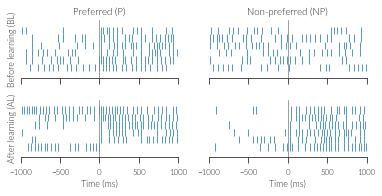

In [15]:
i = 1
p_stim = 'L' + str(i)
np_stim = 'P' + str(i)

dt = 1e-3
t = (np.arange(-1., 1., dt) + dt) * 1e3

fig = plt.figure(figsize=(textwidth, 1.25 * row_height))

ax1 = fig.add_subplot(2, 2, 1)
ax1.eventplot(events_for_stim(t, long_sliced_bl, p_stim, p_stim), lw=0.75)
ax1.set_title("Preferred (P)")
ax1.set_ylabel("Before learning (BL)")

ax2 = fig.add_subplot(2, 2, 2)
ax2.eventplot(events_for_stim(t, long_sliced_bl, p_stim, np_stim), lw=0.75)
ax2.set_title("Non-preferred (NP)")

ax3 = fig.add_subplot(2, 2, 3)
ax3.eventplot(events_for_stim(t, long_sliced_al, p_stim, p_stim), lw=0.75)
ax3.set_xlabel("Time (ms)")
ax3.set_ylabel("After learning (AL)")

ax4 = fig.add_subplot(2, 2, 4)
ax4.eventplot(events_for_stim(t, long_sliced_al, p_stim, np_stim), lw=0.75)
ax4.set_xlabel("Time (ms)")

for ax in fig.axes:
    ax.yaxis.set_ticks([])
    ax.axvline(x=0., color='gray', lw=0.75)
    ax.set_xlim(-1e3, 1e3)
    ax.label_outer()
sns.despine(fig, left=True)
fig.tight_layout()

In [16]:
save_tight_fig(fig, '../../../phd-thesis/figures/aml-spikes.pdf')